In [2]:
%matplotlib inline

In [85]:
# %load poi_id.py
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi". # You will need to use more features
##### 'email_address' fails featureFormat() as it is string not float, all other features imported for 
##### initial testing and investigations
features_list = ['poi', 'salary', 'bonus','deferral_payments','total_payments',  
                 'exercised_stock_options','restricted_stock','total_stock_value',
                 'expenses','deferred_income',
                 'long_term_incentive', 'other',
                 'restricted_stock_deferred', 'loan_advances', 'director_fees', 
                 'to_messages', 'shared_receipt_with_poi','from_messages',      
                 'from_this_person_to_poi', 'from_poi_to_this_person'             
                ] 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers - remove TOTAL from financials    
total_financials = data_dict.pop('TOTAL')
### Negative outliers found in deferred_income and restricted stock deferred
### Entries for 'BELFER ROBERT' & 'BHATANGAR SANJAY' corrected as confirmed by enron61702insiderpay.pdf

data_dict['BELFER ROBERT']['deferred_income']  = -102500
data_dict['BELFER ROBERT']['deferral_payments']= 'NaN'
data_dict['BELFER ROBERT']['expenses'] = 3285
data_dict['BELFER ROBERT']['director_fees'] = 102500 
data_dict['BELFER ROBERT']['total_payments'] = 3285
data_dict['BELFER ROBERT']['exercised_stock_options']= 'NaN'
data_dict['BELFER ROBERT']['restricted_stock']= 44093
data_dict['BELFER ROBERT']['restricted_stock_deferred']= -44093
data_dict['BELFER ROBERT']['total_stock_value'] = 'NaN'

data_dict['BHATNAGAR SANJAY']['other']= 'NaN' 
data_dict['BHATNAGAR SANJAY']['expenses']= 137864
data_dict['BHATNAGAR SANJAY']['director_fees']= 'NaN'
data_dict['BHATNAGAR SANJAY']['total_payments']= 137864
data_dict['BHATNAGAR SANJAY']['exercised_stock_options']= 15456290 
data_dict['BHATNAGAR SANJAY']['restricted_stock']= 2604490
data_dict['BHATNAGAR SANJAY']['restricted_stock_deferred']= -2604490
data_dict['BHATNAGAR SANJAY']['total_stock_value']= 15456290


In [86]:
### Task 3: Create new feature(s)

## create dataframe of dict with features as cols and names as index
#https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
from __future__ import division
import numpy as np
import pandas as pd

df_data = pd.DataFrame.from_dict({(i): data_dict[i]
                           for i in data_dict.keys()},
                           orient='index')


#list of features that are numbers
numbers = list(df_data)  
numbers.remove('email_address') 
numbers.remove('poi')

#ensure pd.dataframe values are 'float' for mathematical operations
for trait in [numbers]:
    df_data[trait] = df_data[trait].astype('float')

# new features:
 
df_data['take_home'] = df_data['salary'] + df_data['bonus']
df_data['percent_exercised'] = df_data['exercised_stock_options']/df_data['total_stock_value']
df_data['response_rate'] = df_data['from_messages']/df_data['to_messages']
df_data['poi_response'] = df_data['from_this_person_to_poi']/df_data['from_poi_to_this_person']

new_features=['take_home', 'percent_exercised', 'response_rate', 'poi_response']
numbers = numbers + new_features 

##Replace inf with NaN
#df_data.dropna(0,'all') -> no rows with all empty features
df_data = df_data.replace(np.inf, np.nan)
#df_data.plot.box(rot=90)

##Data Prepocessing: Imputation and Scaling 
imputed_data = df_data.copy()
for col in numbers:
    ave =  imputed_data[col].mean()
    imputed_data[col] = imputed_data[col].replace(np.nan, ave)

#print imputed_data.describe()
#imputed_data.plot.box(rot=90)

## Scale in pd.dataframe MinMaxScaler-type for all features
scaled_data = imputed_data.copy()
scaled_data = ((imputed_data - imputed_data.min())/(imputed_data.max()-imputed_data.min())).astype('float')

#my_features = ['poi','exercised_stock_options', 'take_home','salary','total_payments',
#               'long_term_incentive','deferred_income','shared_receipt_with_poi', 'from_poi_to_this_person',
#               'from_this_person_to_poi','from_messages','to_messages','percent_exercised'] 

## Removed features: 
## 'restricted_stock_deferred', 17 entries; 'loan_advances', 3 entries; 'director_fees',16 entries
##  'deferral_payments, 38 entries (73% NaNs)
##      -limited entries <10%, 2 have no POIs to classify on
my_features = ['poi','salary', 'bonus','total_payments',  
               'exercised_stock_options','restricted_stock','total_stock_value',
               'expenses','deferred_income',
               'long_term_incentive', 'other',
               'to_messages', 'shared_receipt_with_poi','from_messages',      
               'from_this_person_to_poi', 'from_poi_to_this_person',
              # 'restricted_stock_deferred','loan_advances','director_fees', #Removed - too few points
              # 'deferral_payments',
              'take_home', 'percent_exercised', 'response_rate', 'poi_response' # New features
              ]

## Store new features and corrections to my_dataset dictionary for easy export below.
my_data_imputed = imputed_data.to_dict(orient='index')
my_dataset = scaled_data.to_dict(orient='index')


In [87]:
### Separate Labels,Features
### Split sets for train/test data 

### Extract features and labels from dataset for local testing
def feature_extraction(mydata_dict, features_lineup):
    data = featureFormat(mydata_dict, features_lineup, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    return labels,features

def split_sets(features, labels, test_amt, r_state): 
    from sklearn.cross_validation import train_test_split
    f_train, f_test, l_train, l_test = \
    train_test_split(features, labels, test_size=test_amt, random_state=r_state)
    return f_train, f_test, l_train, l_test   



labels, features = feature_extraction(my_dataset, my_features)
features_train, features_test, labels_train, labels_test = split_sets(features, labels, 0.3, 42)

In [88]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SelectPercentile, f_classif, chi2

## Rank Features with various Feature Selection Methods
## Create VarianceThreshold object to rank feature variances
thresholder = VarianceThreshold()
high_variance = thresholder.fit(features)
## List Features with Ranked variances (ascending)
t_vars = thresholder.variances_
t_vars_sort = np.argsort(thresholder.variances_)
print "VarianceThreshold:"
for i in t_vars_sort:
    print i, my_features[i+1], t_vars[i]

######################
## KBest takes Featues, target(labels), select k features
kbest = SelectKBest(f_regression).fit(features, labels)
k_scoresort = np.argsort(kbest.scores_)
k_pvals  = kbest.pvalues_
print "########  SelectKBest:"
for f in k_scoresort:
    print my_features[f+1], 'score: ', kbest.scores_[f], k_pvals[f]

#####################    
## Select Percentile, default selection function: the 10% most significant features
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features, labels)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
print "##########  SelectPercentile:"
for f in np.argsort(scores):
    print my_features[f+1], 'score: ', scores[f], k_pvals[f]


VarianceThreshold:
2 total_payments 0.00701774170406
17 response_rate 0.00872125736411
12 from_messages 0.00964067890612
9 other 0.0112865940958
8 long_term_incentive 0.0127547254362
18 poi_response 0.0138938560388
5 total_stock_value 0.0155315859128
13 from_this_person_to_poi 0.0158289148948
14 from_poi_to_this_person 0.0159079544005
0 salary 0.0163097677222
4 restricted_stock 0.0170307112056
10 to_messages 0.0171674418646
1 bonus 0.0182353044714
3 exercised_stock_options 0.0185360298835
15 take_home 0.0196470077065
7 deferred_income 0.0235621082693
11 shared_receipt_with_poi 0.0267211346123
6 expenses 0.0273537619761
16 percent_exercised 0.0504267569086
########  SelectKBest:
percent_exercised score:  0.00132141741985 0.971052936222
to_messages score:  0.370461777688 0.543718301293
expenses score:  0.405485442931 0.525287901605
from_messages score:  0.58945562335 0.443895601483
poi_response score:  0.657418845918 0.418820057253
response_rate score:  0.72703437007 0.395272007919
from_

('take_home', 'bonus') 0.995309445937
('bonus', 'take_home') 0.995309445937
('total_stock_value', 'exercised_stock_options') 0.938867717086
('exercised_stock_options', 'total_stock_value') 0.938867717086
('from_messages', 'response_rate') 0.926513951173
('response_rate', 'from_messages') 0.926513951173
('to_messages', 'shared_receipt_with_poi') 0.847990014598
('shared_receipt_with_poi', 'to_messages') 0.847990014598
('other', 'total_payments') 0.826466938137
('total_payments', 'other') 0.826466938137


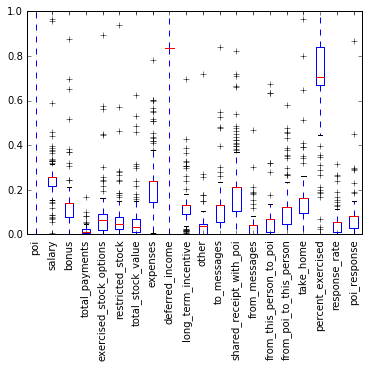

In [89]:
## Review Features: correlation matrix pandas, boxplot, statistics
## https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

#scaled_data.describe()

s= scaled_data.corr()
s_order = s.unstack().sort_values(ascending=False)

for key, value in s_order.iteritems():
    if value > 0.8 and value !=1:
        print key, value
        
scaled_data[my_features].plot.box(rot=90)

In [386]:
## my_features top scores from Variance Threshold, SelectKBest/SelectPercentile Order, remove high correlation
#my_features = ['poi','exercised_stock_options', 'total_stock_value',
#               'salary','bonus', 'total_payments',
#               'restricted_stock','long_term_incentive',
#               'deferred_income','shared_receipt_with_poi',
#               'from_poi_to_this_person',
#               'other', 'from_this_person_to_poi', 'from_messages', 'expenses'
#                ]

my_features = ['poi', 'exercised_stock_options', 'take_home',
               'salary', 'total_payments',
               'restricted_stock','long_term_incentive',
               #'deferred_income','shared_receipt_with_poi',
               #'from_poi_to_this_person', 'other', 
               #'from_this_person_to_poi'
              ]

labels, features = feature_extraction(my_dataset, my_features)
features_train, features_test, labels_train, labels_test = split_sets(features, labels, 0.3, 42)
print "Features: ", len(my_features)-1

Features:  6


In [ ]:
from sklearn.cross_validation import StratifiedShuffleSplit

## Function: test_classifier(clf, dataset, feature_list, folds)
def test_classifier(clf, dataset, feature_list, folds):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

In [388]:
###########################
## Pipeline for feature reduction with PCA()/SelectKBest
## http://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html
#sphx-glr-auto-examples-compose-plot-compare-reduction-py
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC

sss = StratifiedShuffleSplit(labels, 100, random_state = 42)

pipe = Pipeline([
    ('reduce_dim', SelectKBest()),
    ('classify', GaussianNB())
])

N_FEATURES_OPTIONS = [1, 3, 5]
S_FUNC = [f_regression, f_classif]
C_OPTIONS = [5, 10, 25, 50]
param_grid = [
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'reduce_dim__score_func': S_FUNC,
    #    'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classify__C': C_OPTIONS
    }, 

]
## Function: test_classifier(clf, dataset, feature_list, folds)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=sss)
grid.fit(features, labels)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
#mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
#mean_scores = mean_scores.max(axis=0)
print "Pipeline Feature Reductions PCA()/SelectKBest with SCV classifier"
print mean_scores
print grid.best_score_
grid.cv_results_['params'][grid.best_index_]

Pipeline Feature Reductions PCA()/SelectKBest with SCV classifier
[ 0.86733333  0.86733333  0.83933333  0.83933333  0.85666667  0.85666667
  0.87066667  0.86333333  0.848     ]
0.870666666667


{'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 1}

In [396]:
print features[1]

[ 0.0072226   0.16346077  0.25532535  0.00176051  0.07823137  0.13342003]


In [398]:
## Pipeline for classifier selection with one feature reduction

from sklearn.naive_bayes import GaussianNB
from sklearn import tree, neighbors
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

sss = StratifiedShuffleSplit(labels, 100, random_state = 42)
pipe2 = Pipeline([
    ('reduce_dim', SelectKBest()),
    ('classify', GaussianNB())
])

N_FEATURES_OPTIONS = [1]
C_OPTIONS = [5, 10, 25, 50, 100]
SPLITS = [2, 10, 15, 20]
WEIGHTS = ['distance', 'uniform']
NACHBARN = [5, 10, 50]
ESTIMATES = [2,10,25,50]

param_grid = [
    {
       'reduce_dim__k': N_FEATURES_OPTIONS,
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify': [SVC()],
        'classify__C': C_OPTIONS 
    },
    {
        'reduce_dim__k': N_FEATURES_OPTIONS,
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS, 
        'classify': [GaussianNB()]
    },
    {
        'reduce_dim__k': N_FEATURES_OPTIONS,
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify': [tree.DecisionTreeClassifier()],
        'classify__min_samples_split': SPLITS 
    },
    {
       'reduce_dim__k': N_FEATURES_OPTIONS,
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify': [neighbors.KNeighborsClassifier()],
        'classify__n_neighbors': NACHBARN,
        'classify__weights': WEIGHTS
    },
    {
        'reduce_dim__k': N_FEATURES_OPTIONS,
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify': [RandomForestClassifier()],
        'classify__n_estimators': ESTIMATES
    },
    #{
    #    'reduce_dim__k': N_FEATURES_OPTIONS,
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classify': [AdaBoostClassifier()],
    #    'classify__n_estimators': ESTIMATES
    #}
]



grid = GridSearchCV(pipe2, param_grid=param_grid, cv= sss)
grid.fit(features, labels)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
#mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
#mean_scores = mean_scores.max(axis=0)
print "Pipeline with various classifiers"
print mean_scores
print grid.best_score_
grid.cv_results_['params'][grid.best_index_]

Pipeline with various classifiers
[ 0.87866667  0.878       0.86866667  0.86866667  0.86933333  0.86733333
  0.84133333  0.852       0.85133333  0.85133333  0.848       0.87066667
  0.86        0.86666667  0.846       0.86666667  0.846       0.83866667
  0.83666667  0.83666667]
0.878666666667


{'classify': SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False), 'classify__C': 5, 'reduce_dim__k': 1}

In [ ]:
#########################################################
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

##http://scikit-learn.org/0.16/auto_examples/model_selection/grid_search_digits.html#example-model-selection-grid-search-digits-py
## 

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC


## Load/Prepare dataset
labels, features = feature_extraction(my_data_imputed, my_features)
#labels, features = feature_extraction(my_dataset, my_features)

## Transform all data with chosen reducer -> :
#reducer = SelectKBest(f_regression, k=10)
#reducer = reducer.fit(features, labels)
#reduced = reducer.transform(features)
#reducer = PCA(n_components = 15)
#reducer = reducer.fit(features, labels)
#reduced = reducer.transform(features)

## Split dataset in two parts for cross validation
#features_train, features_test, labels_train, labels_test = split_sets(reduced, labels, 0.3, 42)

sss = StratifiedShuffleSplit(labels, 100, random_state = 42)


pipe3 = Pipeline([
    ('reduce_dim', SelectKBest(k=1)),
    ('classify', SVC())
])


## Set tuning parameters for cross-validation

cees = [1, 3, 5, 10, 25] # C values
kay = [1,3,6]
tune_SVCparameters = [{'classify__kernel': ['rbf'],
                       'classify__C': cees,
                       'classify__gamma': [1e-5, 1e-6, 'auto']
                      },
                      {'classify__kernel': ['linear'],
                       'classify__C': cees},
                      {'classify__kernel': ['poly'],   
                       'classify__C': cees, 
                       'classify__degree':[3, 4, 5],
                       'classify__gamma': [1e-5, 1e-6, 'auto']
                      }
                     ]

tune_RFparameters = [{'n_estimators': [9,10,12,15],
                      'criterion': ['gini','entropy'],
                      'min_samples_split': [2,3,4,5],
#                     'min_samples_leaf': [1,2,3],
                      'max_features': ['auto', 1, 0.5]
                     }
                  ]

tune_ADAparameters = [{'reduce_dim__k': kay,
                       'classify__n_estimators': [2,5,50,100],
                       'classify__algorithm': ['SAMME','SAMME.R'],
                       'classify__learning_rate': [1, 0.5],
                     }
                  ]

print("Parameter Tuning\n")

clf = GridSearchCV(pipe3, tune_SVCparameters, cv=sss)
clf.fit(features, labels)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("\nGrid scores on development set:")

for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
print()

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n")
y_true, y_pred = labels_test, clf.predict(features_test)
print(classification_report(y_true, y_pred))
print()

### Precision Recall AND F1 Metrics
def prec_recall(model, pred, labels_test):
    from sklearn.metrics import precision_score, recall_score, f1_score
    y_true = labels_test
    y_pred = pred
    print model 
    print "Precision:", precision_score(y_true, y_pred)  
    print "Recall:", recall_score(y_true, y_pred)  
    print "F1 Score:", f1_score(y_true, y_pred)
    
    
prec_recall(clf, y_pred, y_true)


Parameter Tuning



In [258]:
## Make Classifier PCA() -> RandomForestClassifier()
from sklearn.pipeline import make_pipeline
clf2 = Pipeline([('reduce_dim', PCA(n_components = 9)),
                 ('classifier', SVC(C=50, kernel = 'rbf', gamma = 'auto', random_state = 42)) 
                 #('classifier',  RandomForestClassifier(criterion='gini', max_features= 1,
                  #                          min_samples_split=2, n_estimators=10))
                    ])

In [259]:
clf2 = clf2.fit(features_train, labels_train)
print "Testing score:",clf2.score(features_test, labels_test)
y_true, y_pred = labels_test, clf2.predict(features_test)
prec_recall(clf2, y_pred, y_true)

Testing score: 0.886363636364
Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
Precision: 0.333333333333
Recall: 0.25
F1 Score: 0.285714285714


In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)